In [302]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [270]:
def CV(sweep_rate=0.001, over_potential=0.2, under_potential=-0.2):
    ## INDEPENDENT VARIABLES ##
    C      = 1.0;    # [=] mol/cm^3, initial concentration of O. Default = 1.0
    D      = 0.00001;   # [=] cm^2/s, O & R diffusion coefficient. Default = 1E-5
    etai   = over_potential;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
    etaf   = under_potential;   # [=] V, final overpotential (relative to redox potential). Default = -0.2
    v      = sweep_rate;   # [=] V/s, sweep rate. Default = 1E-3
    n      = 1.0;    # [=] number of electrons transfered. Default = 1
    alpha  = 0.5;    # [=] dimensionless charge-transfer coefficient. Default = 0.5
    k0     = 0.01;   # [=] cm/s, electrochemical rate constant. Default = 1E-2
    kc     = 0.001;   # [=] 1/s, chemical rate constant. Default = 1E-3
    T      = 298.15; # [=] K, temperature. Default = 298.15

    ## PHYSICAL CONSTANTS ##
    F      = 96485;   # [=] C/mol, Faraday's constant
    R      = 8.3145;  # [=] J/mol-K, ideal gas constant
    f      = F/(R*T); # [=] 1/V, normalized Faraday's constant at room temperature

    ## SIMULATION VARIABLES ##
    L      = 500;    # [=] number of iterations per t_k (pg 790). Default = 500
    DM     = 0.45;   # [=] model diffusion coefficient (pg 788). Default = 0.45

    ## DERIVED CONSTANTS ##
    tk  = 2*(etai-etaf)/v;    # [=] s, characteristic exp. time (pg 790). In this case, total time of fwd and rev scans
    Dt  = tk/L;               # [=] s, delta time (Eqn B.1.10, pg 790)
    Dx  = np.sqrt(D*Dt/DM);      # [=] cm, delta x (Eqn B.1.13, pg 791)
    j   = int(np.ceil(4.2*L**0.5)+5);  # number of boxes (pg 792-793). If L~200, j=65

    ## REVERSIBILITY PARAMETERS ##
    ktk    = kc*tk              # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
    km     = ktk/L              # normalized dimensionless kinetic parameter (see bottom of pg 797)
    Lambda = k0/(D*f*v)**0.5     # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)

    ## CHEMICAL REVERSIBILITY WARNING ##
    #if km>0.1:
       # warning(['k_c*t_k/l equals ' num2str(km) ...
       #     ', which exceeds the upper limit of 0.1 (see B&F, pg 797)'])


    ## PRE-INITIALIZATION ##
    k = np.linspace(0,L,L+1);# time index vector
    t = Dt * k;             # time vector
    eta1 = etai - v*t;      # overpotential vector, negative scan
    eta2 = etaf + v*t;      # overpotential vector, positive scan
    eta = np.concatenate((eta1[0:250], eta2[0:251])).T # overpotential scan, both directions
    Enorm = eta*f;          # normalized overpotential
    kf = k0*np.exp(  -alpha *n*Enorm); # [=] cm/s, fwd rate constant (pg 799)
    kb = k0*np.exp((1-alpha)*n*Enorm); # [=] cm/s, rev rate constant (pg 799)

    O = C*np.ones((L+1,j)); # [=] mol/cm^3, concentration of O
    R = np.zeros((L+1,j));  # [=] mol/cm^3, concentration of R
    JO = np.zeros((1,L+1)); # [=] mol/cm^2-s, flux of O at the surface
    ## START SIMULATION ##
    # i1 = time index. i2 = distance index
    for i1 in range(0,L):
        # Update bulk concentrations of O and R
        for i2  in range(1,j-1):
            O[i1+1,i2] = O[i1,i2] + DM*(O[i1,i2+1]+O[i1,i2-1]-2*O[i1,i2])

            R[i1+1,i2] = R[i1,i2] + DM*(R[i1,i2+1]+R[i1,i2-1]-2*R[i1,i2]) - km * R[i1,i2]

        # Update flux
        JO[0][i1+1]   = ( kf[i1+1]*O[i1+1,2] - kb[i1+1]*R[i1+1,2] ) / (1 + Dx/D*(kf[i1+1] + kb[i1+1]) );

        # Update surface concentrations
        O[i1+1,1] = O[i1+1,2] - JO[0][i1+1]*(Dx/D);
        R[i1+1,1] = R[i1+1,2] + JO[0][i1+1]*(Dx/D) - km*R[i1+1,1];

    # Calculate current density, Z, from flux of O
    Z = -n*F*JO/10; # [=] A/m^2 -> mA/cm^2, current density
    
    return eta, Z

In [275]:
def I_p(eta,Z):
    X=eta[250:320].reshape(70,1)
    y=Z[250:320].reshape(70,1)
    lin_reg = LinearRegression()
    result = lin_reg.fit(X,y)
    max_index=np.where(Z==max(Z))[0][0]
    X_predict = np.array([[under_potential], [eta[max_index]]])
    y_predict = lin_reg.predict(X_predict)
    i_p=max(Z)-y_predict[-1]
    return i_p, X_predict, y_predict

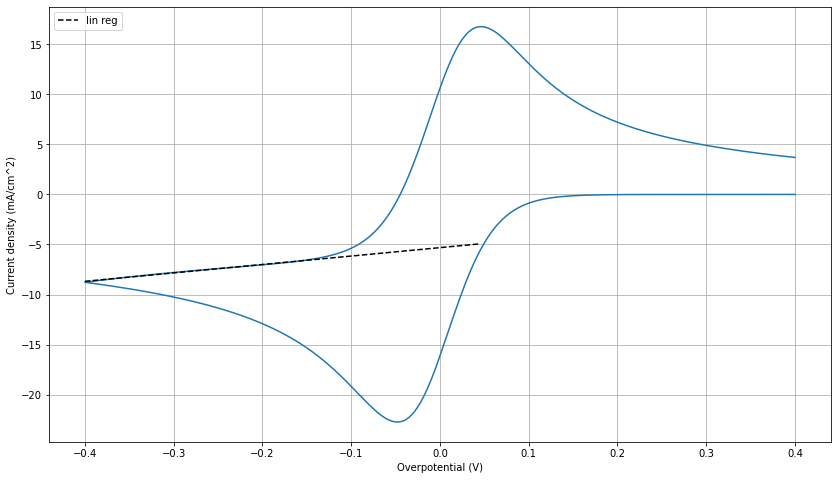

In [277]:
fig, axs = plt.subplots(1,1,figsize=(14,8))
sweep_rate=np.array([50,100,150,250,300])*10**(-3)
ax=axs
under_potential=-0.4
eta, Z =CV(sweep_rate=sweep_rate[1], over_potential=0.4, under_potential=under_potential)
Z=Z.reshape(501,)
ax.plot(eta,Z)
    
i_p, X_predict, y_predict = I_p(eta,Z)

ax.plot(X_predict,y_predict, 'k--', label='lin reg')
ax.plot([eta[max_index], eta[max_index]], [y_predict[-1], np.amax(Z)], 'k', label=r'$i_p$')

ax.set_xlabel('Overpotential (V)')
ax.set_ylabel('Current density (mA/cm^2)')
ax.grid()
ax.legend(loc='upper left')

C:\Users\tomas\Anaconda3\envs\tif285-env\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


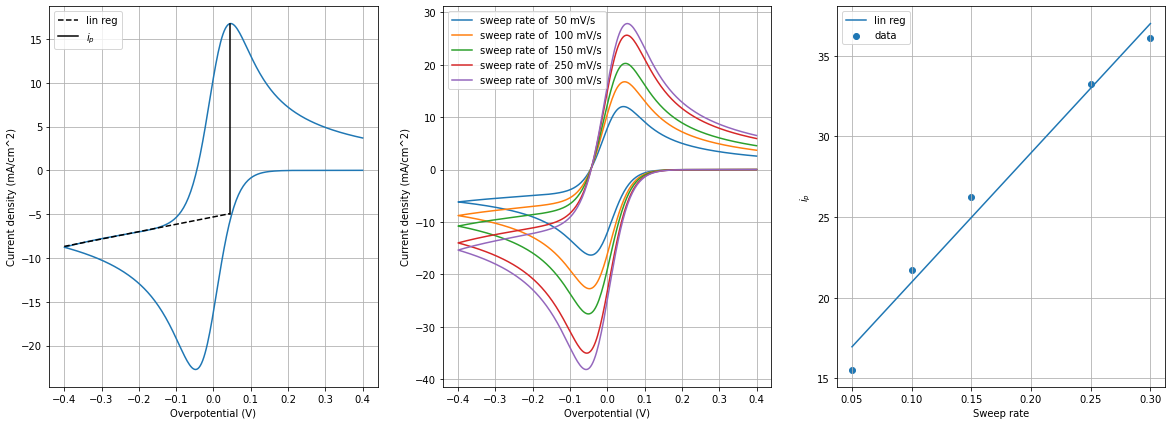

In [307]:
fig, axs = plt.subplots(1,3,figsize=(20,7))
sweep_rate=np.array([50,100,150,250,300])*10**(-3)
ax=axs[0]
under_potential=-0.4
eta, Z =CV(sweep_rate=sweep_rate[1], over_potential=0.4, under_potential=under_potential)
Z=Z.reshape(501,)
ax.plot(eta,Z)
    
i_p, X_predict, y_predict = I_p(eta,Z)

ax.plot(X_predict,y_predict, 'k--', label='lin reg')
ax.plot([eta[max_index], eta[max_index]], [y_predict[-1], np.amax(Z)], 'k', label=r'$i_p$')

ax.set_xlabel('Overpotential (V)')
ax.set_ylabel('Current density (mA/cm^2)')
ax.grid()
ax.legend(loc='upper left')

ax=axs[1]
i_p_list = []
for sr in sweep_rate:
    eta, Z =CV(sweep_rate=sr, over_potential=0.4, under_potential=under_potential)
    Z=Z.reshape(501,)
    ax.plot(eta,Z.reshape(501,), label=f'sweep rate of {sr/10**(-3): .0f} mV/s')
    i_p, x, y = I_p(eta, Z)
    i_p_list.append(i_p)
    
ax.set_xlabel('Overpotential (V)')
ax.set_ylabel('Current density (mA/cm^2)')
ax.grid()
ax.legend(loc='upper left')
ax=axs[2]
ax.scatter(sweep_rate,i_p_list, label='data')
lin_reg = LinearRegression()
i_p_list =np.array(i_p_list)
result = lin_reg.fit(sweep_rate.reshape(len(sweep_rate),1),i_p_list.reshape(len(sweep_rate),1))
X_predict = np.array([[sweep_rate[0]], [sweep_rate[-1]]])
y_predict = lin_reg.predict(X_predict)
ax.plot(X_predict, y_predict, label='lin reg')
ax.set_xlabel('Sweep rate')
ax.set_ylabel(r'$i_p$')
ax.grid()
ax.legend()

fig.savefig('cv.png')